In [11]:
import pandas as pd
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
# Load the CSV files
train_df = pd.read_csv('Train.csv')
test_df = pd.read_csv('Test.csv')


# Data Preprocessing (Splitting Dataset and Stratified Sampling)

In [13]:
# Sample 600 images from each class, avoiding the warning
balanced_train_df = (
    train_df.groupby('class', as_index=False)  # Keep the grouping column
    .apply(lambda x: x.sample(n=600, random_state=42))
    .reset_index(drop=True)
)

# Split the balanced dataset into training and validation sets
train_data, val_data = train_test_split(
    balanced_train_df, 
    test_size=0.2, 
    random_state=42, 
    stratify=balanced_train_df['class']
)

# Sizes of the datasets
print("Size of Balanced Training Set:", balanced_train_df.shape[0])
print("Size of Training Set:", train_data.shape[0])
print("Size of Validation Set:", val_data.shape[0])
print("Size of Test Set:", test_df.shape[0])



Size of Balanced Training Set: 1800
Size of Training Set: 1440
Size of Validation Set: 360
Size of Test Set: 1178


C:\Users\selgo\AppData\Local\Temp\ipykernel_2060\3326931599.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=600, random_state=42))


# Data Analysis

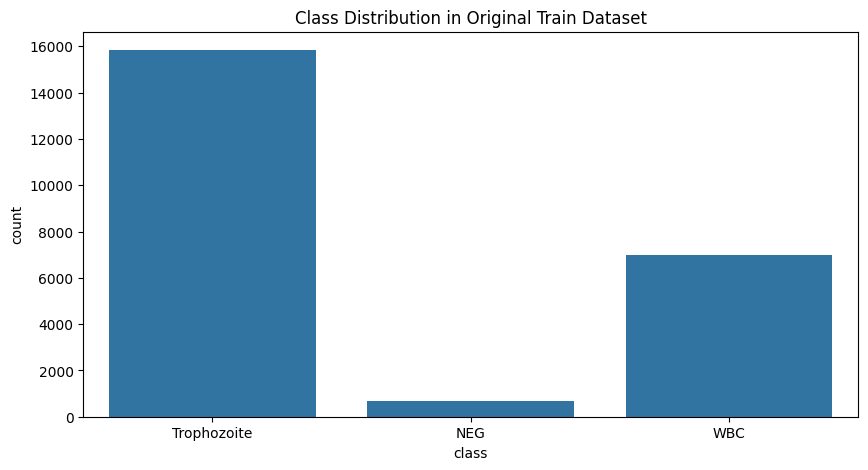

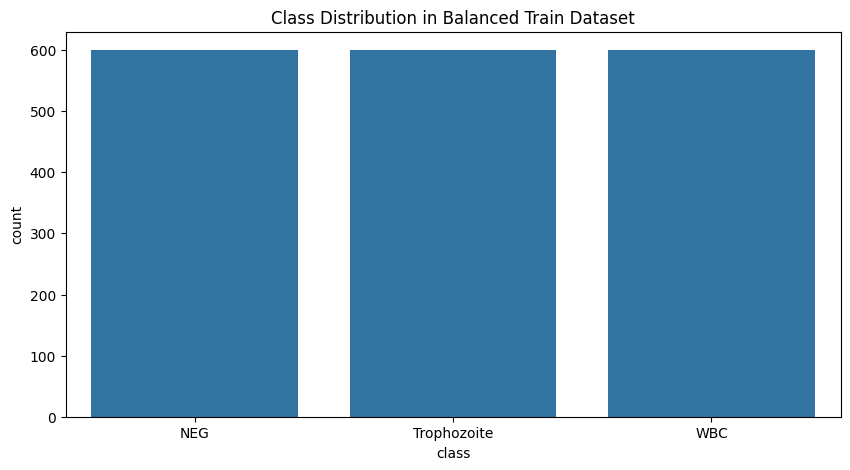

In [14]:
# 1. Plot class distribution in the original and balanced dataset
plt.figure(figsize=(10, 5))
sns.countplot(data=train_df, x='class')
plt.title("Class Distribution in Original Train Dataset")
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(data=balanced_train_df, x='class')
plt.title("Class Distribution in Balanced Train Dataset")
plt.show()

Sample image paths:
0    images\id_u3q6jdck4j.jpg
1    images\id_a6cl90trri.jpg
2    images\id_qvc2le9sm8.jpg
3    images\id_w8xnbd5rvm.jpg
4    images\id_6dop09rk02.jpg
Name: image_path, dtype: object
Available columns: ['Image_ID', 'class', 'confidence', 'ymin', 'xmin', 'ymax', 'xmax']


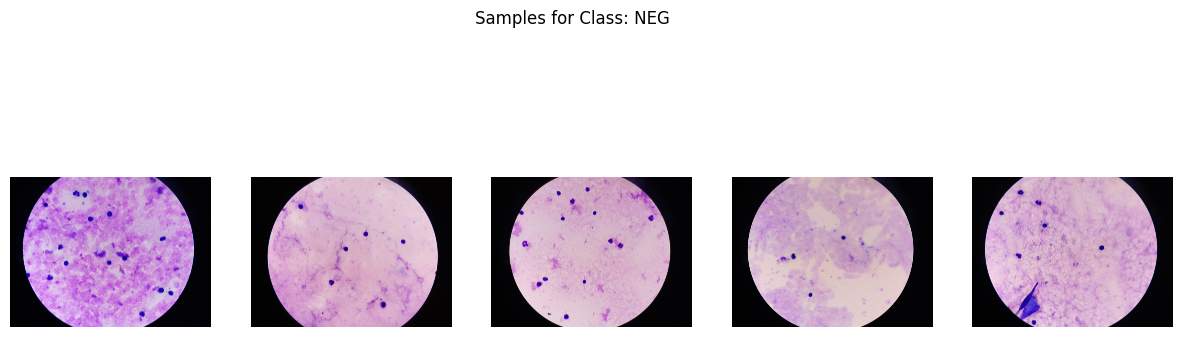

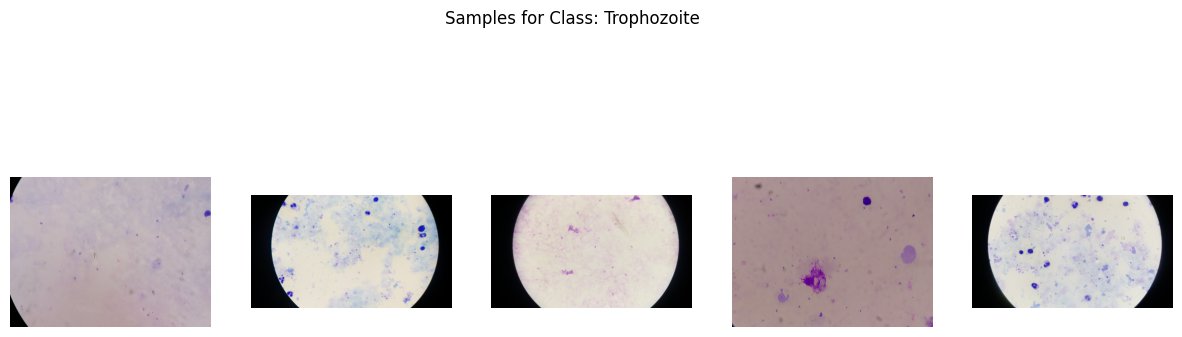

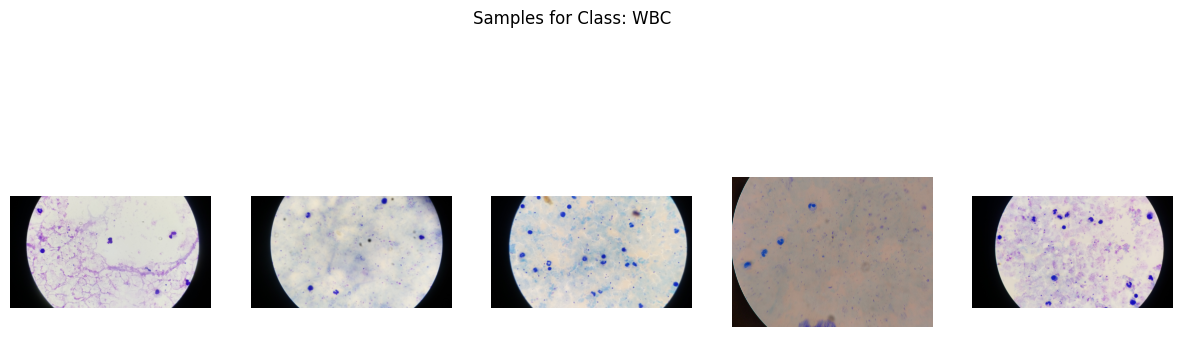

In [15]:
# 2. Display sample images from each class

train_df['image_path'] = train_df['Image_ID'].apply(lambda x: os.path.join('images', x))

print("Sample image paths:")
print(train_df['image_path'].head())

print("Available columns:", balanced_train_df.columns.tolist())

balanced_train_df['image_path'] = balanced_train_df['Image_ID'].apply(
    lambda x: os.path.join('images', x)
)

missing_files = train_df[~train_df['image_path'].apply(os.path.exists)]
if not missing_files.empty:
    print(f"Missing files:\n{missing_files[['Image_ID', 'image_path']]}")


def plot_image_samples(df, class_name, n_samples=5):
    plt.figure(figsize=(15, 5))
    sample_df = df[df['class'] == class_name].sample(n=n_samples, random_state=42)
    for i, idx in enumerate(sample_df.index):
        img_path = sample_df.loc[idx, 'image_path']
        img = cv2.imread(img_path)
        
        if img is None: 
            print(f"Warning: Image at {img_path} not found.")
            continue
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f'Samples for Class: {class_name}')
    plt.show()

for cls in balanced_train_df['class'].unique():
    plot_image_samples(balanced_train_df, cls)

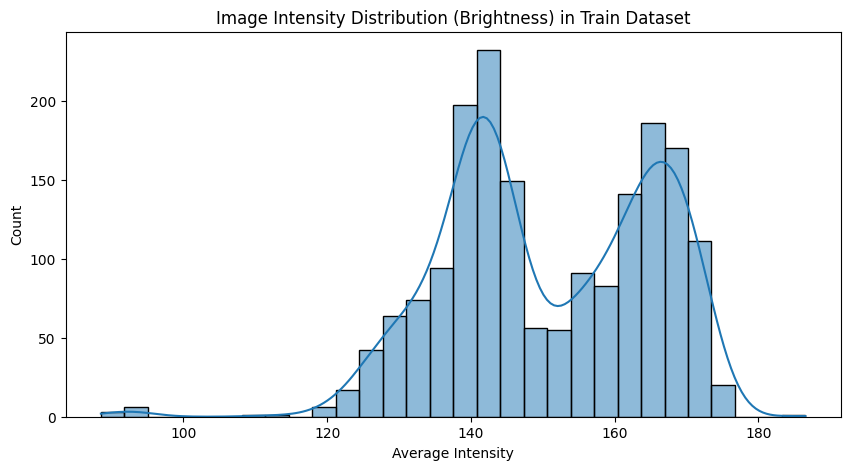

In [16]:
# 3. Calculate image intensity distribution (brightness)
brightness = []

for img_path in balanced_train_df['image_path']:  
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    brightness.append(np.mean(img))

plt.figure(figsize=(10, 5))
sns.histplot(brightness, kde=True, bins=30)
plt.title("Image Intensity Distribution (Brightness) in Train Dataset")
plt.xlabel("Average Intensity")
plt.show()



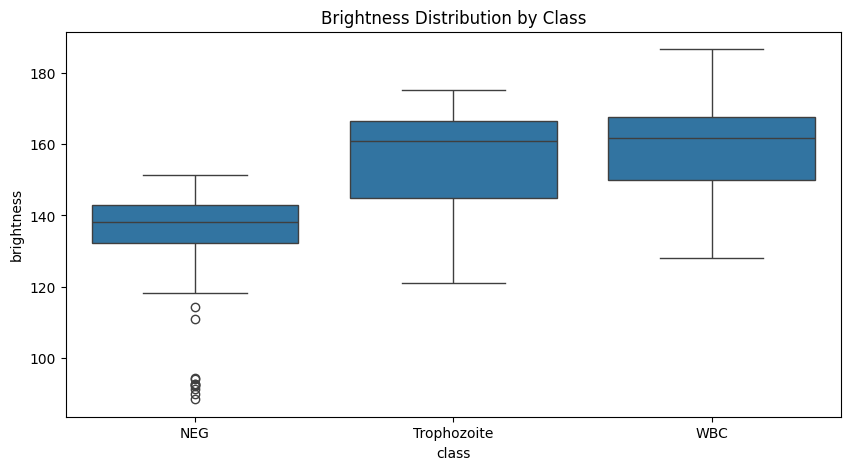

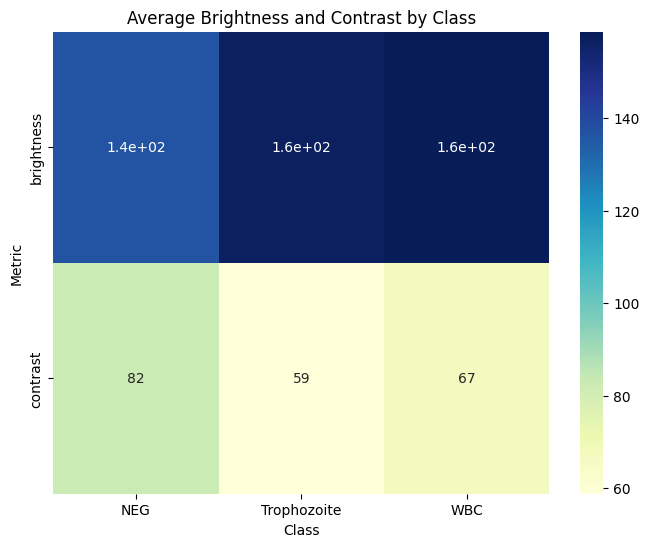

In [17]:
# 4. Class-wise brightness comparison
brightness_class = []

for _, row in balanced_train_df.iterrows():
    img = cv2.imread(row['image_path'], cv2.IMREAD_GRAYSCALE)
    avg_brightness = np.mean(img)
    brightness_class.append((row['class'], avg_brightness))

brightness_df = pd.DataFrame(brightness_class, columns=['class', 'brightness'])

plt.figure(figsize=(10, 5))
sns.boxplot(data=brightness_df, x='class', y='brightness')
plt.title("Brightness Distribution by Class")
plt.show()


# 3. Brightness and Contrast Heatmap by Class
stats_df = pd.DataFrame({
    'class': balanced_train_df['class'],
    'brightness': brightness,
    'contrast': [np.std(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)) for img_path in balanced_train_df['image_path']]
})
brightness_contrast_avg = stats_df.groupby('class')[['brightness', 'contrast']].mean().reset_index()
plt.figure(figsize=(8, 6))
sns.heatmap(brightness_contrast_avg.set_index('class').T, annot=True, cmap="YlGnBu", cbar=True)
plt.title("Average Brightness and Contrast by Class")
plt.xlabel("Class")
plt.ylabel("Metric")
plt.show()

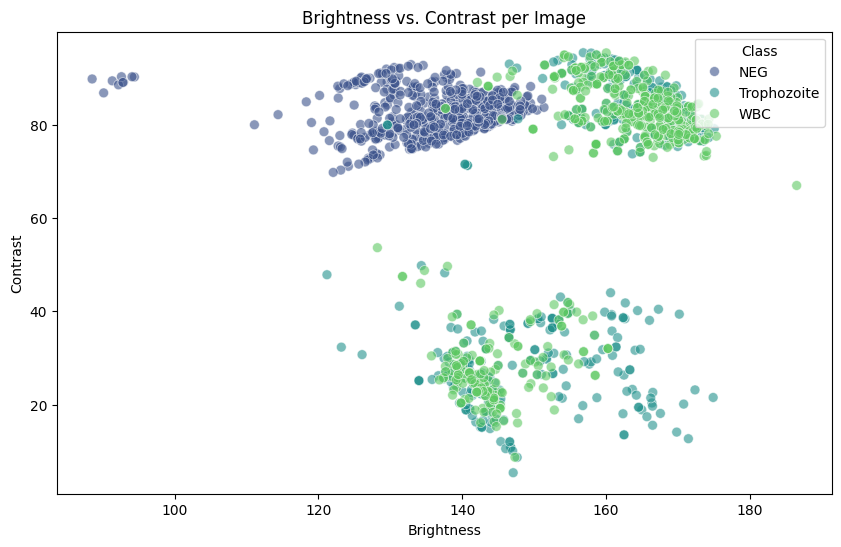

In [18]:
# 5. Brightness vs. Contrast Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=stats_df, x='brightness', y='contrast', hue='class', palette="viridis", alpha=0.6, s=50)
plt.title("Brightness vs. Contrast per Image")
plt.xlabel("Brightness")
plt.ylabel("Contrast")
plt.legend(title='Class', loc='upper right')
plt.show()

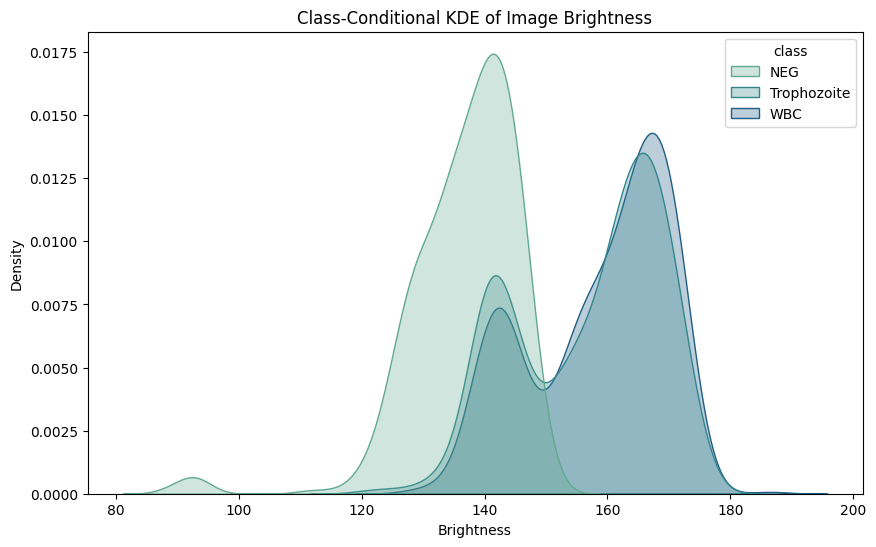

In [19]:
# 6. Class-Conditional KDE for Brightness
plt.figure(figsize=(10, 6))
sns.kdeplot(data=brightness_df, x='brightness', hue='class', fill=True, palette="crest", alpha=0.3)
plt.title("Class-Conditional KDE of Image Brightness")
plt.xlabel("Brightness")
plt.show()



Index(['class', 'brightness', 'contrast'], dtype='object')


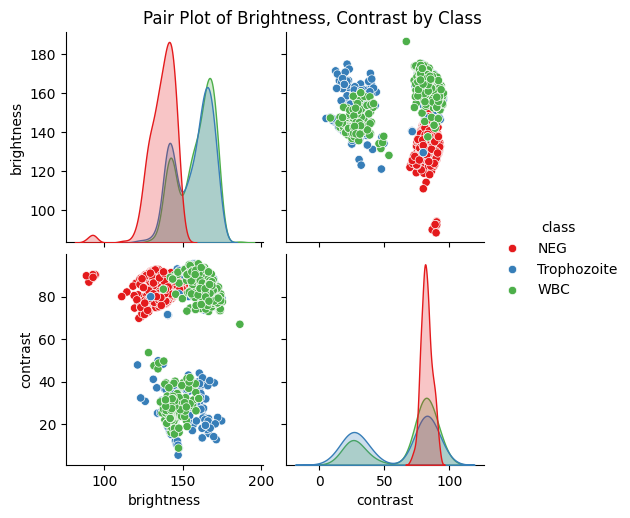

In [21]:
# 8. Pair Plot for Brightness, Contrast, and Size
print(stats_df.columns)

sns.pairplot(stats_df, vars=["brightness", "contrast"], hue="class", palette="Set1", height=2.5)
plt.suptitle("Pair Plot of Brightness, Contrast by Class", y=1.02)
plt.show()

In [22]:
# 9. Image Size Distribution
def get_image_dimensions(img_path):
    img = cv2.imread(img_path)
    if img is not None:
        return img.shape[0], img.shape[1]
    return None, None

heights = []
widths = []

for img_path in balanced_train_df['image_path']:
    h, w = get_image_dimensions(img_path)
    if h is not None and w is not None:
        heights.append(h)
        widths.append(w)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(heights, bins=30, kde=True)
plt.title("Image Height Distribution")
plt.xlabel("Height (pixels)")

plt.subplot(1, 2, 2)
sns.histplot(widths, bins=30, kde=True)
plt.title("Image Width Distribution")
plt.xlabel("Width (pixels)")
plt.tight_layout()
plt.show()

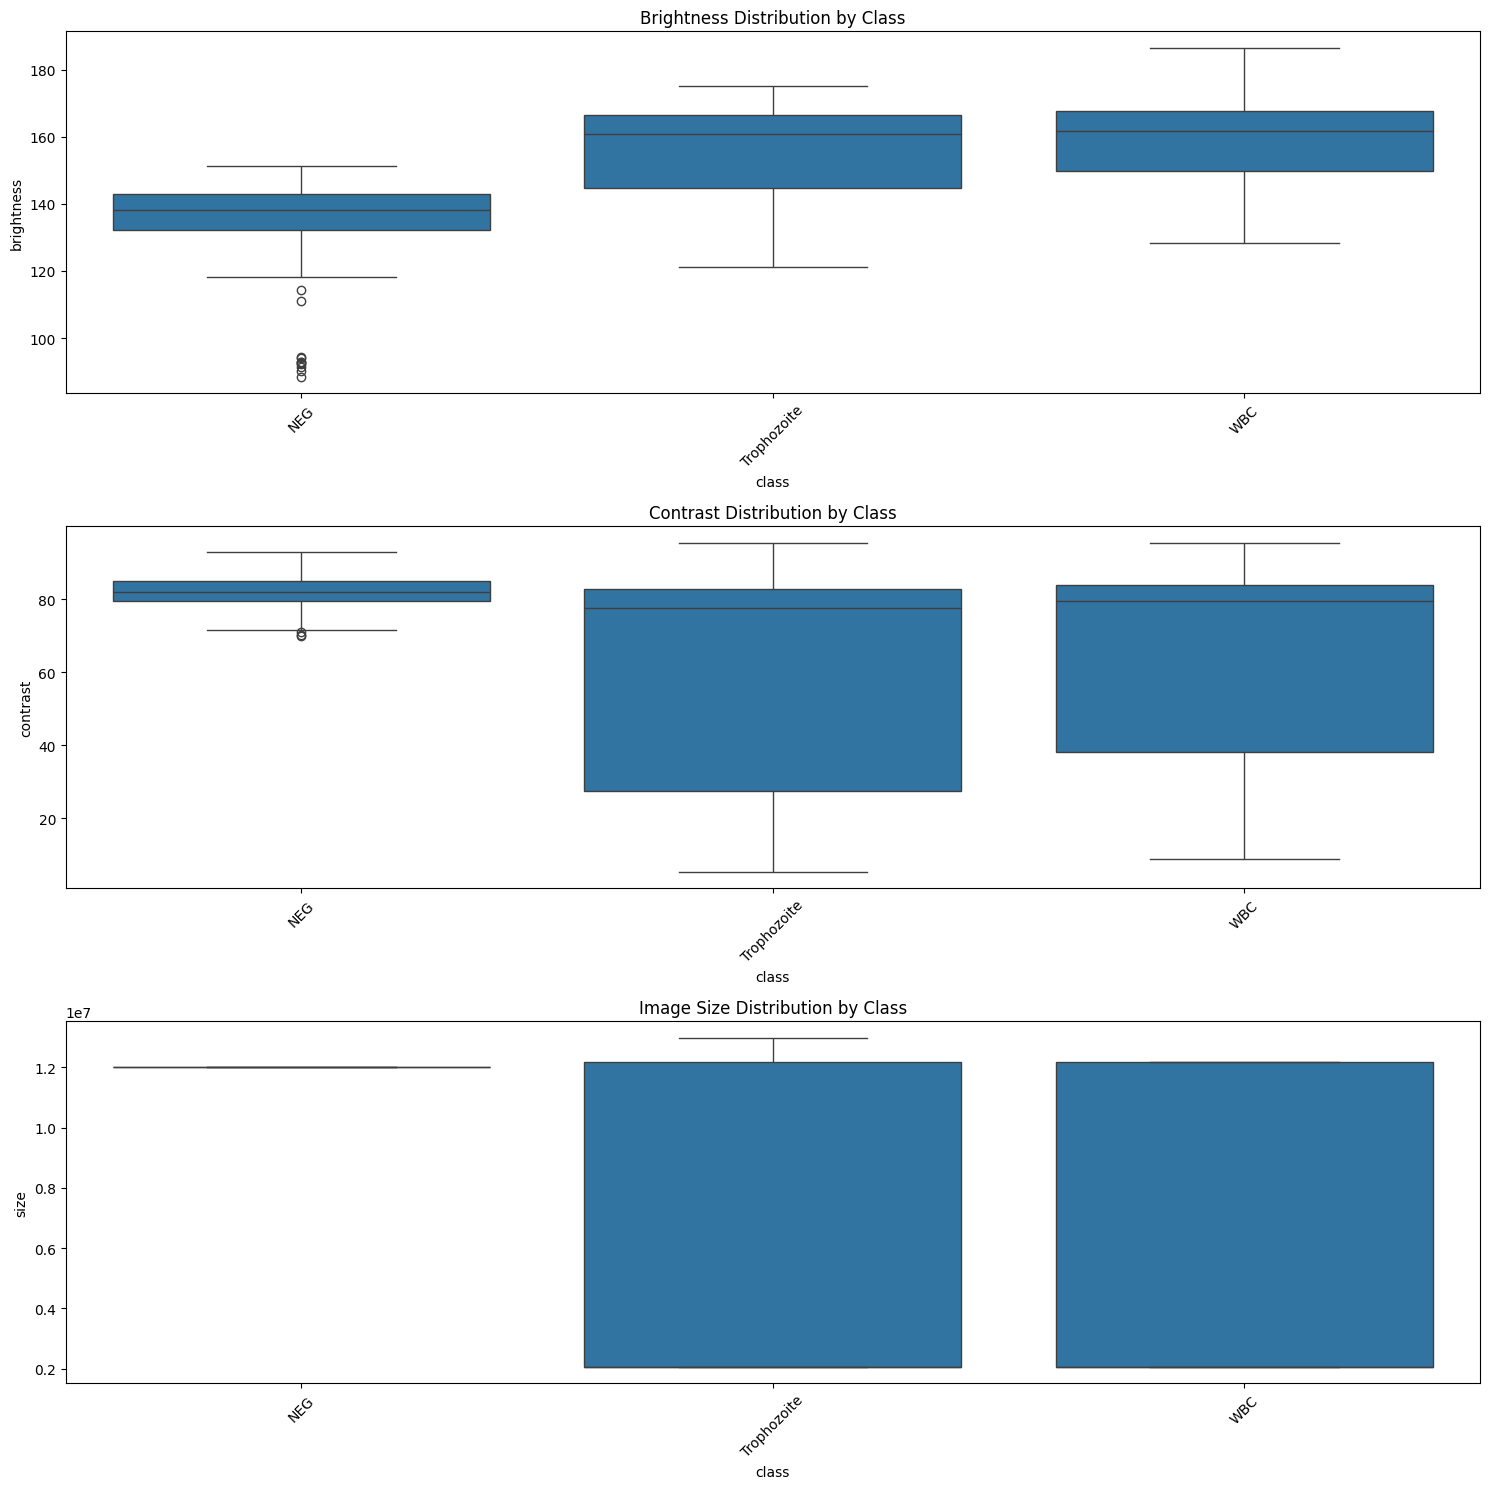

In [23]:
# 10. Image Statistics by Class
class_stats = []

for _, row in balanced_train_df.iterrows():
    img = cv2.imread(row['image_path'])
    if img is not None:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        class_stats.append({
            'class': row['class'],
            'brightness': np.mean(img_gray),
            'contrast': np.std(img_gray),
            'size': img.shape[0] * img.shape[1]
        })

stats_df = pd.DataFrame(class_stats)

# Plot statistics by class
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

sns.boxplot(data=stats_df, x='class', y='brightness', ax=axes[0])
axes[0].set_title('Brightness Distribution by Class')
axes[0].tick_params(axis='x', rotation=45)

sns.boxplot(data=stats_df, x='class', y='contrast', ax=axes[1])
axes[1].set_title('Contrast Distribution by Class')
axes[1].tick_params(axis='x', rotation=45)

sns.boxplot(data=stats_df, x='class', y='size', ax=axes[2])
axes[2].set_title('Image Size Distribution by Class')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

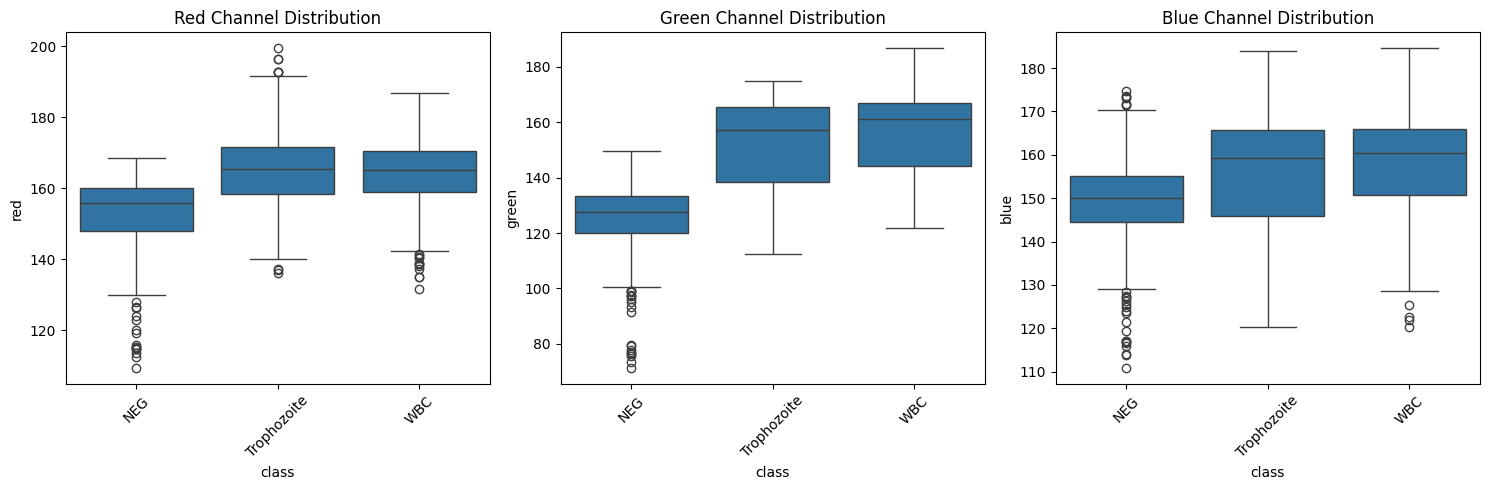

In [24]:
# 11. Color Distribution Analysis
def get_color_distribution(image_path):
    img = cv2.imread(image_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return [np.mean(img[:,:,0]), np.mean(img[:,:,1]), np.mean(img[:,:,2])]
    return None

color_stats = []
for _, row in balanced_train_df.iterrows():
    colors = get_color_distribution(row['image_path'])
    if colors:
        color_stats.append({
            'class': row['class'],
            'red': colors[0],
            'green': colors[1],
            'blue': colors[2]
        })

color_df = pd.DataFrame(color_stats)

# Plot RGB distributions
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(data=color_df, x='class', y='red')
plt.title('Red Channel Distribution')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.boxplot(data=color_df, x='class', y='green')
plt.title('Green Channel Distribution')
plt.xticks(rotation=45)


plt.subplot(1, 3, 3)
sns.boxplot(data=color_df, x='class', y='blue')
plt.title('Blue Channel Distribution')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [25]:
# 12. Correlation Matrix of Image Features
feature_df = pd.DataFrame({
    'brightness': stats_df['brightness'],
    'contrast': stats_df['contrast'],
    'size': stats_df['size'],
    'red': color_df['red'],
    'green': color_df['green'],
    'blue': color_df['blue']
})

plt.figure(figsize=(10, 8))
sns.heatmap(feature_df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Image Features')
plt.tight_layout()
plt.show()

C:\Users\selgo\AppData\Local\Temp\ipykernel_2060\2527909686.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=stats_df, x='class', y='brightness', ax=axes[0], palette="viridis")
C:\Users\selgo\AppData\Local\Temp\ipykernel_2060\2527909686.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=stats_df, x='class', y='contrast', ax=axes[1], palette="coolwarm")
C:\Users\selgo\AppData\Local\Temp\ipykernel_2060\2527909686.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=stats_df, x='class', y='size', ax=axes[2], palette="magma"

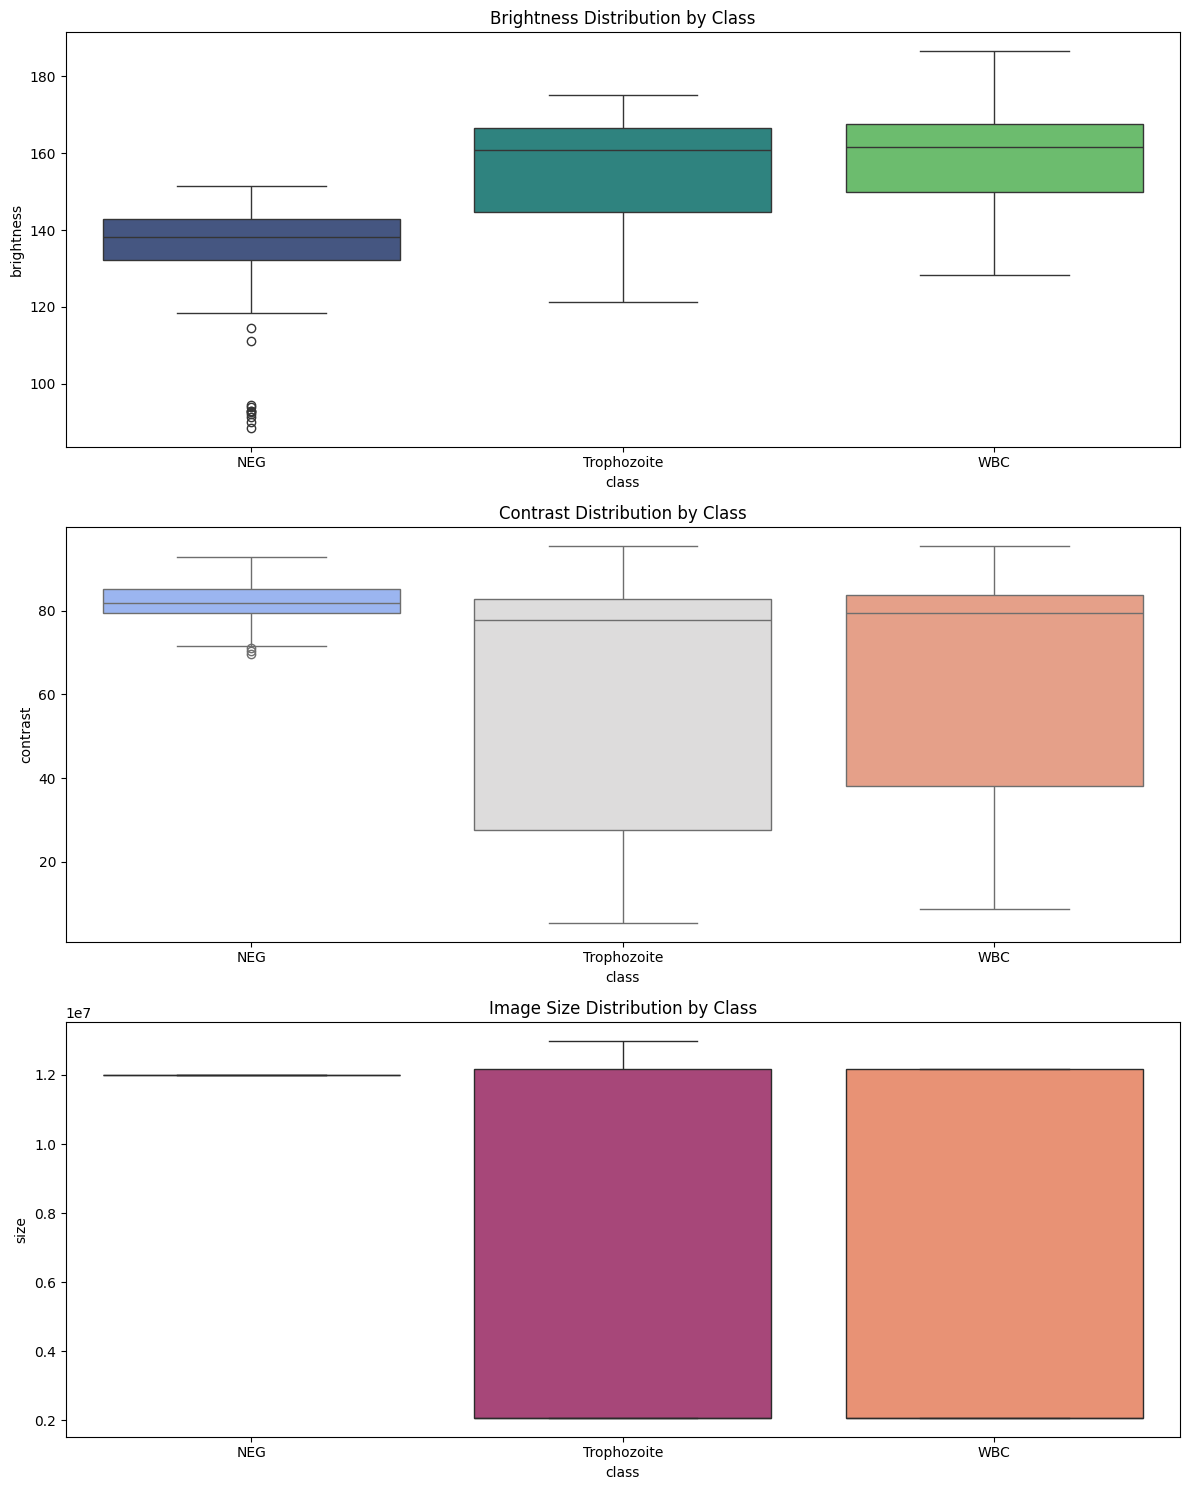

In [26]:
# 13. Image Statistics by Class (Brightness, Contrast, and Size)
# Analyzes each class in terms of brightness, contrast, and total pixel count

class_stats = []

for _, row in balanced_train_df.iterrows():
    img = cv2.imread(row['image_path'])
    if img is not None:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        class_stats.append({
            'class': row['class'],
            'brightness': np.mean(img_gray),
            'contrast': np.std(img_gray),
            'size': img.shape[0] * img.shape[1]
        })

stats_df = pd.DataFrame(class_stats)

# Plot each statistic by class
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

sns.boxplot(data=stats_df, x='class', y='brightness', ax=axes[0], palette="viridis")
axes[0].set_title('Brightness Distribution by Class')

sns.boxplot(data=stats_df, x='class', y='contrast', ax=axes[1], palette="coolwarm")
axes[1].set_title('Contrast Distribution by Class')

sns.boxplot(data=stats_df, x='class', y='size', ax=axes[2], palette="magma")
axes[2].set_title('Image Size Distribution by Class')

plt.tight_layout()
plt.show()

C:\Users\selgo\AppData\Local\Temp\ipykernel_2060\586869050.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=color_df, x='class', y='red', ax=axs[0], palette="Reds")
C:\Users\selgo\AppData\Local\Temp\ipykernel_2060\586869050.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=color_df, x='class', y='green', ax=axs[1], palette="Greens")
C:\Users\selgo\AppData\Local\Temp\ipykernel_2060\586869050.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=color_df, x='class', y='blue', ax=axs[2], palette="Blues")


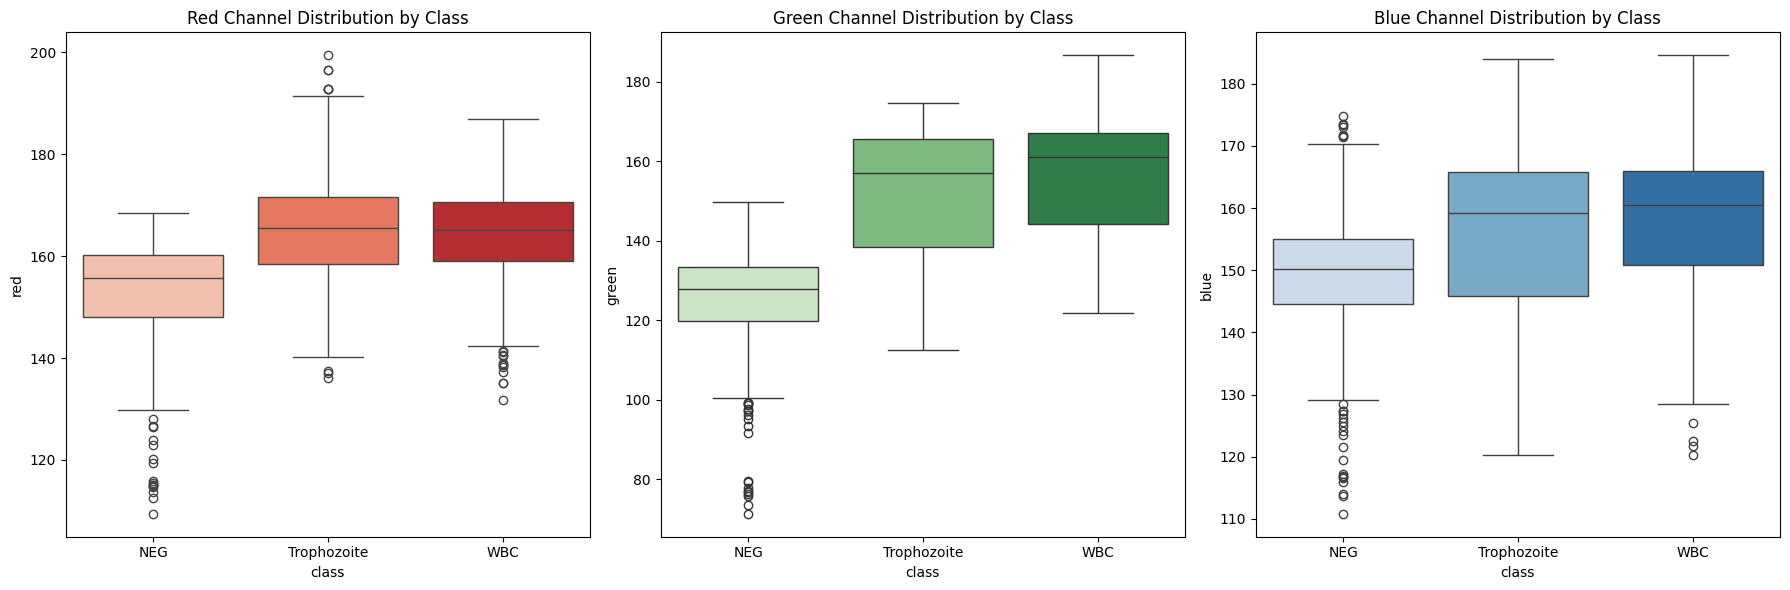

In [27]:
# 14. Color Distribution Analysis (Red, Green, Blue channels)
# Evaluates the average color channel intensity for each class to detect color-based trends

def compute_color_distribution(image_path):
    img = cv2.imread(image_path)
    if img is not None:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return [np.mean(img_rgb[:, :, i]) for i in range(3)]
    return None

color_stats = []
for _, row in balanced_train_df.iterrows():
    color_dist = compute_color_distribution(row['image_path'])
    if color_dist:
        color_stats.append({
            'class': row['class'],
            'red': color_dist[0],
            'green': color_dist[1],
            'blue': color_dist[2]
        })

color_df = pd.DataFrame(color_stats)

# Plot RGB channel distributions by class
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(data=color_df, x='class', y='red', ax=axs[0], palette="Reds")
axs[0].set_title("Red Channel Distribution by Class")

sns.boxplot(data=color_df, x='class', y='green', ax=axs[1], palette="Greens")
axs[1].set_title("Green Channel Distribution by Class")

sns.boxplot(data=color_df, x='class', y='blue', ax=axs[2], palette="Blues")
axs[2].set_title("Blue Channel Distribution by Class")

plt.tight_layout()
plt.show()

In [28]:
# Reset index for both dataframes
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)

# Data Preprocessing (Categorial Encoding)

In [29]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    channel_shift_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='images',
    x_col='Image_ID',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory='images',
    x_col='Image_ID',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='images',
    x_col='Image_ID',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
    
)


print("Class Indices:")
print(train_generator.class_indices)

print("\nNumber of classes:", len(train_generator.class_indices))

class_labels = [k for k, v in sorted(train_generator.class_indices.items(), key=lambda item: item[1])]
print("\nClass labels in order:", class_labels)

print("\nSamples per class:")
for class_name, index in train_generator.class_indices.items():
    count = len(train_data[train_data['class'] == class_name])
    print(f"{class_name}: {count} samples")

Found 1440 validated image filenames belonging to 3 classes.
Found 360 validated image filenames belonging to 3 classes.
Found 1178 validated image filenames.
Class Indices:
{'NEG': 0, 'Trophozoite': 1, 'WBC': 2}

Number of classes: 3

Class labels in order: ['NEG', 'Trophozoite', 'WBC']

Samples per class:
NEG: 480 samples
Trophozoite: 480 samples
WBC: 480 samples


In [30]:

print(f"Number of classes: {len(train_generator.class_indices)}")
print(f"Number of training samples: {len(train_generator)}")
print(f"Number of validation samples: {len(val_generator)}")
print(f"Number of test samples: {len(test_generator)}")

print("\nClass distribution in training data:")
print(train_data['class'].value_counts(normalize=True))
print("\nClass distribution in validation data:")
print(val_data['class'].value_counts(normalize=True))

Number of classes: 3
Number of training samples: 45
Number of validation samples: 12
Number of test samples: 37

Class distribution in training data:
class
WBC            0.333333
Trophozoite    0.333333
NEG            0.333333
Name: proportion, dtype: float64

Class distribution in validation data:
class
Trophozoite    0.333333
WBC            0.333333
NEG            0.333333
Name: proportion, dtype: float64


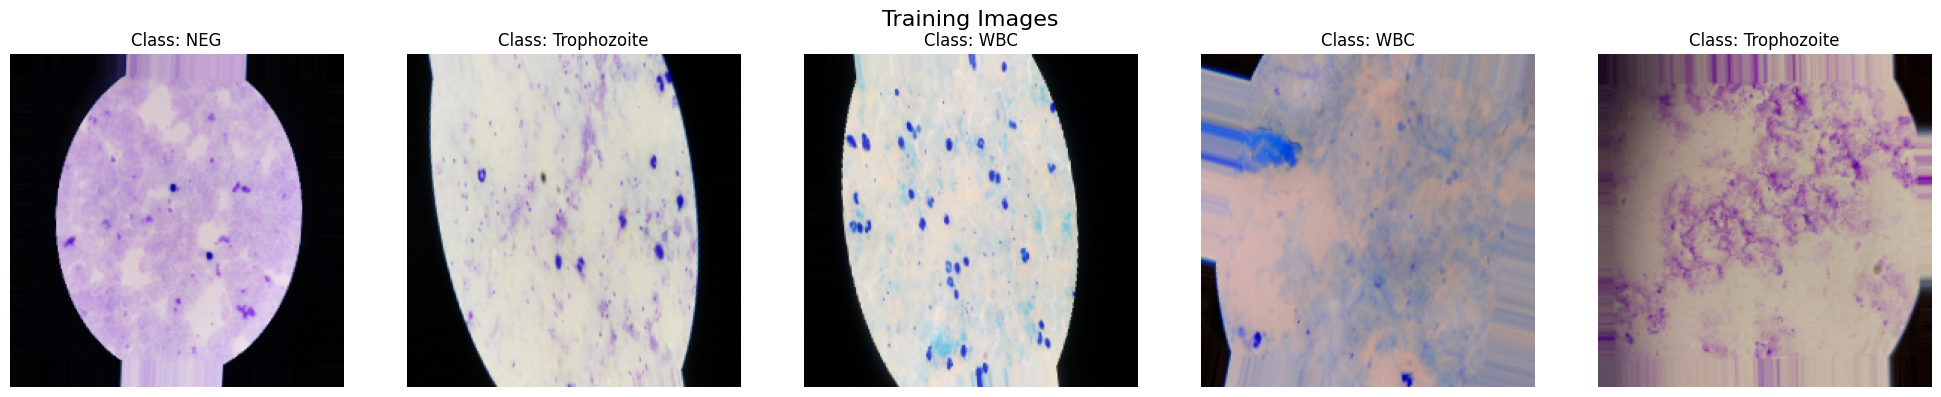

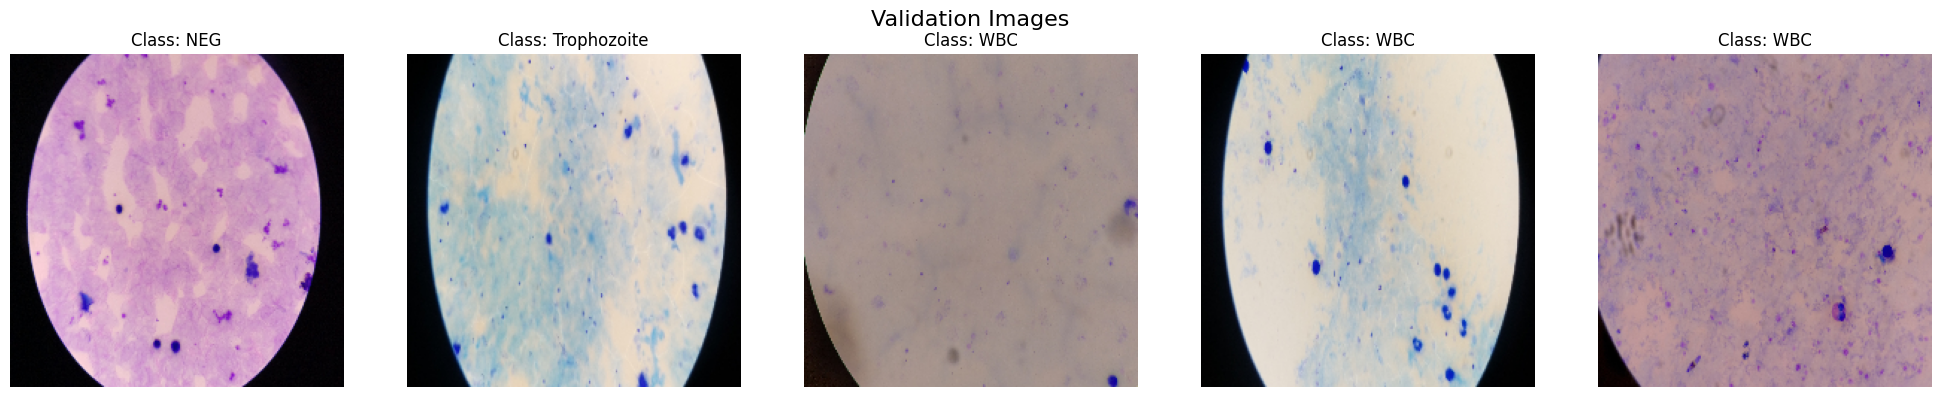

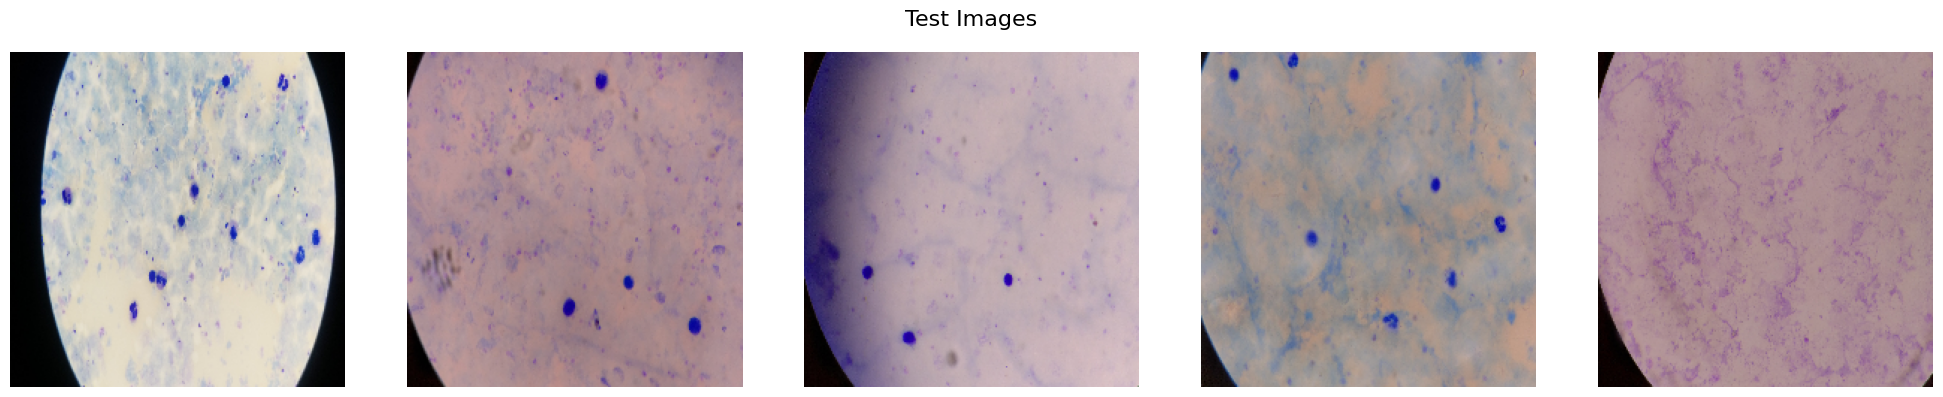

In [31]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def plot_images(generator, title, n=5):
    plt.figure(figsize=(20, 4))
    plt.suptitle(title, fontsize=16)
    
    has_classes = hasattr(generator, 'class_indices')
    
    if has_classes:
        class_indices = generator.class_indices
        index_to_class = {v: k for k, v in class_indices.items()}
    
    for i in range(n):
        batch = next(generator)
        
        if isinstance(batch, tuple):
            images, labels = batch
        else:
            images = batch
        
        idx = np.random.randint(0, images.shape[0])
        img = images[idx]
        
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
        
        if has_classes and isinstance(batch, tuple):
            label_idx = np.argmax(labels[idx])
            class_name = index_to_class[label_idx]
            plt.title(f"Class: {class_name}")
    
    plt.tight_layout()
    plt.show()

plot_images(train_generator, "Training Images")

plot_images(val_generator, "Validation Images")

plot_images(test_generator, "Test Images")

# Classification Model

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split, ParameterGrid

In [33]:

# Data Augmentation with ResNet50 preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

def create_transfer_model(input_shape=(224, 224, 3), num_classes=3):
    """
    Create a transfer learning model based on ResNet50
    """
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    base_model.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

def create_and_train_model(train_generator, val_generator, batch_size, learning_rate, quick_eval=True):
    """
    Creates and trains a model with given hyperparameters for quick evaluation
    """
    model = create_transfer_model()
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    epochs = 1 if quick_eval else 2
    
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        verbose=0
    )
    
    return max(history.history['val_accuracy'])



In [34]:
def perform_grid_search(train_data, val_data, train_datagen, val_datagen):
    """
    Perform grid search for batch size and learning rate
    """
    param_grid = {
        'batch_size': [32, 64],
        'learning_rate': [0.01, 0.0001]
    }
    
    grid = ParameterGrid(param_grid)
    results = np.zeros((len(param_grid['batch_size']), len(param_grid['learning_rate'])))
    total_combinations = len(param_grid['batch_size']) * len(param_grid['learning_rate'])
    current = 0
    
    for i, batch_size in enumerate(param_grid['batch_size']):
        for j, lr in enumerate(param_grid['learning_rate']):
            current += 1
            print(f"\rTesting combination {current}/{total_combinations}: "
                  f"batch_size={batch_size}, learning_rate={lr}", end='')
            
            train_generator = train_datagen.flow_from_dataframe(
                dataframe=train_data,
                directory='images',
                x_col='Image_ID',
                y_col='class',
                target_size=(224, 224),
                batch_size=batch_size,
                class_mode='categorical'
            )
            
            val_generator = val_datagen.flow_from_dataframe(
                dataframe=val_data,
                directory='images',
                x_col='Image_ID',
                y_col='class',
                target_size=(224, 224),
                batch_size=batch_size,
                class_mode='categorical'
            )
            
            val_accuracy = create_and_train_model(
                train_generator,
                val_generator,
                batch_size,
                lr,
                quick_eval=True
            )
            
            results[i, j] = val_accuracy
    
    print("\nGrid search completed!")
    return results, param_grid



In [35]:
def plot_heatmap(results, param_grid):
    """
    Plot heatmap of hyperparameter search results
    """
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        results,
        xticklabels=param_grid['learning_rate'],
        yticklabels=param_grid['batch_size'],
        annot=True,
        fmt='.3f',
        cmap='viridis'
    )
    plt.title('Validation Accuracy for Different Hyperparameters')
    plt.xlabel('Learning Rate')
    plt.ylabel('Batch Size')
    plt.show()
    
    best_i, best_j = np.unravel_index(results.argmax(), results.shape)
    best_batch_size = param_grid['batch_size'][best_i]
    best_lr = param_grid['learning_rate'][best_j]
    best_accuracy = results[best_i, best_j]
    
    print("\nBest Hyperparameters:")
    print(f"Batch Size: {best_batch_size}")
    print(f"Learning Rate: {best_lr}")
    print(f"Validation Accuracy: {best_accuracy:.3f}")
    
    return best_batch_size, best_lr

# Perform hyperparameter optimization
print("Starting hyperparameter optimization...")
results, param_grid = perform_grid_search(train_data, val_data, train_datagen, val_datagen)
batch_size, learning_rate = plot_heatmap(results, param_grid)

# Create data generators with optimized batch size
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='images',
    x_col='Image_ID',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory='images',
    x_col='Image_ID',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='images',
    x_col='Image_ID',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

# Print class information
print("\nClass Information:")
print("Class Indices:", train_generator.class_indices)
print("Number of Classes:", len(train_generator.class_indices))
class_labels = [k for k, v in sorted(train_generator.class_indices.items(), key=lambda item: item[1])]
print("Class Labels:", class_labels)

# Print samples per class
print("\nSamples per Class:")
for class_name, index in train_generator.class_indices.items():
    count = len(train_data[train_data['class'] == class_name])
    print(f"{class_name}: {count} samples")



Starting hyperparameter optimization...
Testing combination 1/4: batch_size=32, learning_rate=0.01Found 1440 validated image filenames belonging to 3 classes.
Found 360 validated image filenames belonging to 3 classes.


c:\Users\selgo\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Testing combination 2/4: batch_size=32, learning_rate=0.0001Found 1440 validated image filenames belonging to 3 classes.
Found 360 validated image filenames belonging to 3 classes.


c:\Users\selgo\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Testing combination 3/4: batch_size=64, learning_rate=0.01Found 1440 validated image filenames belonging to 3 classes.
Found 360 validated image filenames belonging to 3 classes.


c:\Users\selgo\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Testing combination 4/4: batch_size=64, learning_rate=0.0001Found 1440 validated image filenames belonging to 3 classes.
Found 360 validated image filenames belonging to 3 classes.


c:\Users\selgo\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Grid search completed!



Best Hyperparameters:
Batch Size: 64
Learning Rate: 0.0001
Validation Accuracy: 0.728
Found 1440 validated image filenames belonging to 3 classes.
Found 360 validated image filenames belonging to 3 classes.
Found 1178 validated image filenames.

Class Information:
Class Indices: {'NEG': 0, 'Trophozoite': 1, 'WBC': 2}
Number of Classes: 3
Class Labels: ['NEG', 'Trophozoite', 'WBC']

Samples per Class:
NEG: 480 samples
Trophozoite: 480 samples
WBC: 480 samples


In [36]:
# Create and compile model with optimized parameters
model = create_transfer_model(num_classes=len(train_generator.class_indices))
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Create callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_delta=0.001
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# First training phase
print("\nPhase 1: Training top layers...")
history_1 = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# Unfreeze layers for fine-tuning
base_model = model.layers[0]
base_model.trainable = True

base_model.trainable = True

# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=learning_rate * 0.1),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Second training phase (fine-tuning)
print("\nPhase 2: Fine-tuning...")
history_2 = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# Combine histories
def combine_histories(h1, h2):
    history = {}
    for key in h1.history:
        history[key] = h1.history[key] + h2.history[key]
    return history

history = combine_histories(history_1, history_2)




Phase 1: Training top layers...
Epoch 1/10


c:\Users\selgo\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4249 - loss: 1.4374
Epoch 1: val_accuracy improved from -inf to 0.71944, saving model to best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 202s 7s/step - accuracy: 0.4284 - loss: 1.4256 - val_accuracy: 0.7194 - val_loss: 0.6112 - learning_rate: 1.0000e-04
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6284 - loss: 0.7640
Epoch 2: val_accuracy improved from 0.71944 to 0.72222, saving model to best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 251s 10s/step - accuracy: 0.6291 - loss: 0.7630 - val_accuracy: 0.7222 - val_loss: 0.5301 - learning_rate: 1.0000e-04
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7025 - loss: 0.6001
Epoch 3: val_accuracy improved from 0.72222 to 0.73333, saving model to best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 211s 8s/step - accuracy: 0.7024 - loss: 0.6001 - val_accuracy: 0.7333 - val_loss: 0.5043 - learning_rate: 1.0000e-04
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.72

In [37]:
# Plot training history
plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Load best model for evaluation
best_model = tf.keras.models.load_model('best_model.keras')

# Evaluate model
print("\nEvaluating model...")
test_loss, test_accuracy = best_model.evaluate(val_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions
print("\nMaking predictions...")
predictions = best_model.predict(test_generator)

# Create results DataFrame
results_df = pd.DataFrame({
    'Image_ID': test_df['Image_ID'],
    'Predicted_Class': [class_labels[np.argmax(pred)] for pred in predictions],
    'Confidence': [np.max(pred) for pred in predictions]
})

# Save results
results_df.to_csv('predictions.csv', index=False)
print("\nPredictions saved to 'predictions.csv'")

# Print sample predictions
print("\nSample Predictions:")
print(results_df.head())

# Print model summary
print("\nModel Architecture:")
model.summary()


Evaluating model...
6/6 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - accuracy: 0.7674 - loss: 0.4618
Test Accuracy: 0.7667

Making predictions...
19/19 ━━━━━━━━━━━━━━━━━━━━ 159s 8s/step

Predictions saved to 'predictions.csv'

Sample Predictions:
            Image_ID Predicted_Class  Confidence
0  id_5n9ov0rr22.jpg     Trophozoite    0.442270
1  id_k6s11k3klo.jpg     Trophozoite    0.564321
2  id_eftvcf9djb.jpg             WBC    0.696547
3  id_kc5tmoj1xa.jpg     Trophozoite    0.671167
4  id_tirid4qt68.jpg     Trophozoite    0.572160

Model Architecture:


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,200,459 (283.05 MB)

 Trainable params: 24,715,779 (94.28 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 49,431,560 (188.57 MB)